# EfficientNet 
Summary:
* Using pretrained efficientnet_b0, we are able to a get quadratic weighted score ~0.78 and and accuracy ~0.50
* 24 tiles of size 256x256 are extracted from each biopsy image (top 24 by sum of pixel-values, most "non-white" tiles")
* Tiles are stitched back together into a square image and fed into the efficientnet
* 10 epochs ran overnight 

In [1]:
DEBUG = False

In [2]:
#!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [2]:
import os
import sys
#sys.path = ['../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',] + sys.path

In [3]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet, EfficientNet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Settings and Loading Data
* Tiles have been preprocess and stored on disk

In [5]:
tiles_folder = '../data/tiles_data/train_256'

In [6]:
image_ids = {filepath[:32] for filepath in os.listdir(tiles_folder)}

In [25]:
#data_dir = '../input/prostate-cancer-grade-assessment'
df_train = pd.read_csv('../data/train.csv').set_index('image_id')
#image_folder = os.path.join(data_dir, 'train_images')

fold = 0
tile_size = 256
image_size = 256
n_tiles = 16
batch_size = 5
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 2 if DEBUG else 30
df_train = df_train.loc[image_ids].reset_index()
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

In [26]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score
0,26868ac74c4ed809efbae61c6ba15726,karolinska,0,0+0
1,49cf4320931ec7b716d8782ce29c4549,radboud,2,3+4
2,59aa903a1ceb3e9793bedda411a4a2cd,radboud,2,3+4
3,83a54cb1fd656a3cdbd7ac9ffbba9d06,karolinska,3,4+3
4,1b395ce8fd3eee21b0feb260e477a197,radboud,1,3+3


# Create Folds
* Only ended up training with one fold because it took so long. But theoretically, could average models over five folds

In [27]:
skf = StratifiedKFold(5, shuffle=True, random_state=3)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,26868ac74c4ed809efbae61c6ba15726,karolinska,0,0+0,3
1,49cf4320931ec7b716d8782ce29c4549,radboud,2,3+4,3
2,59aa903a1ceb3e9793bedda411a4a2cd,radboud,2,3+4,2
3,83a54cb1fd656a3cdbd7ac9ffbba9d06,karolinska,3,4+3,4
4,1b395ce8fd3eee21b0feb260e477a197,radboud,1,3+3,2


# Model

In [28]:
class enetCustom(nn.Module):
    def __init__(self, out_dim):
        super(enetCustom, self).__init__()
        self.enet = EfficientNet.from_pretrained('efficientnet-b0') 
        self.enet._fc = nn.Linear(self.enet._fc.in_features, out_dim)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.enet(x)
        return x

# Dataset

In [29]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        # Tile mode is zero except during test time as a form of TTA
        self.tile_mode = tile_mode
        # Randomize order in which tiles are stitched together
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        # We've already pre-processed the tiles
        imgs = []
        for i in range(self.n_tiles):
            img = skimage.io.imread(os.path.join(tiles_folder,img_id+f"_{i}.png"))
            imgs.append(img)
        # Final shape is x:  n_tiles x tile_size x tile_size x 3
        imgs = np.array(imgs)
        #print(imgs.shape)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        
        # Stitched image to be square with have shape sqrt(n_tiles) x sqrt (n_tiles)
        n_row_tiles = int(np.sqrt(self.n_tiles))
        mosaic = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                # If the orignal image had more than n_tiles number of tiles (some don't)
                if len(imgs) > idxes[i]:
                    this_img = imgs[idxes[i]]
                # Otherwise create whitespace tile
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                mosaic[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            mosaic = self.transform(image=mosaic)['image']
        mosaic = mosaic.astype(np.float32)
        mosaic /= 255
        mosaic = mosaic.transpose(2, 0, 1)  # shape: 3 x (n_row_tiles*tile_size) x (n_row_tiles*tile_size)
        
        """
        We saw an interesting label encoding being used on Kaggle. Users are creating a 
        length 5 vector (0-5 ISUP scale) and filling the first n positions with 1's corresponding to an ISUP 
        score of n. So if ISUP=3 then the label is [1,1,1,0,0]
        The result is we optimize for a multi-label classification problem
        """
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(mosaic), torch.tensor(label)


# Augmentations

In [30]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    #albumentations.augmentations.transforms.Rotate(limit=20,p=0.5) 
    # Would rotate work as stitched tiles aren't a true image?
])
transforms_val = albumentations.Compose([])

In [31]:
train_ds = PANDADataset(df_train, image_size, n_tiles, 0, rand=False, transform=transforms_train)

In [32]:
img, label = train_ds[0]

In [33]:
img.shape

torch.Size([3, 1024, 1024])

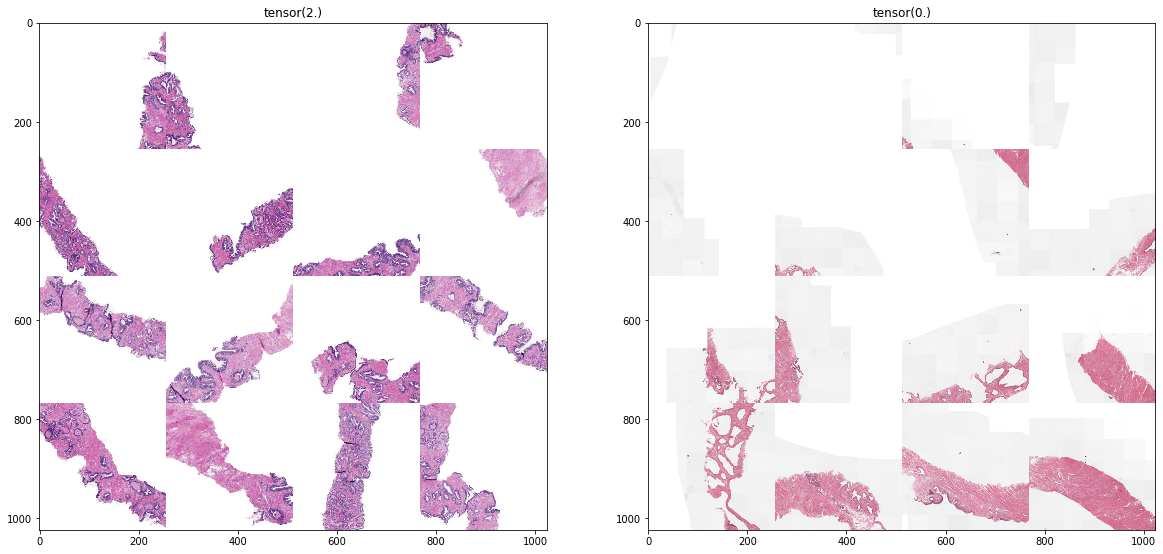

In [43]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, rand=False, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(1):
    f, axarr = plt.subplots(1,2)
    for p in range(2):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1-img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [19]:
"""
As mentioned in the data set, we are label encoding our ISUP Scores as if they are a multi-label
problem. With ISUP score 4 corresponding to [1,1,1,1,0]
"""
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [20]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        # Saw other users using smoothed loss to show average loss from last 100 batches vs current one
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader):

    model.eval()
    val_loss = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)
            # To convert from multi-lable logits to an integer score 0-5 we take sigmoids 
            # (5 scores from 0 to 1) and then sum and round
            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [21]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetCustom(out_dim=out_dim)
model = model.to(device)

# Using one epoch at 3e-5 to warmup model, and then remaining epochs with CosineAnnealingLR starting at 3e-4
optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

Loaded pretrained weights for efficientnet-b0
8492 2124


# Run Training

In [ ]:
qwk_max = 0.0
best_file = f'../models/efficientnet_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)
    print(f'lr: {optimizer.param_groups[0]["lr"]:.7f}')

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'../logs/log_efficientnet.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), f'../models/efficientnet_best_{qwk:.3f}_qwk_fold{fold}.pth')
        qwk_max = qwk

torch.save(model.state_dict(), f'../models/efficientnet_final_fold{fold}.pth')



Sun Jun 21 22:39:14 2020 Epoch: 1
lr: 0.0000300


/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate yo

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



qwk 0.5924098562362954 qwk_k 0.5215994044620725 qwk_r 0.5204050849920628
Sun Jun 21 23:21:05 2020 Epoch 1, lr: 0.0000300, train loss: 0.46570, val loss: 0.43255, acc: 29.56685, qwk: 0.59241
score2 (0.000000 --> 0.592410).  Saving model ...
Sun Jun 21 23:21:05 2020 Epoch: 2
lr: 0.0003000



qwk 0.6585033365654427 qwk_k 0.5845805775269034 qwk_r 0.5834160603473376
Mon Jun 22 00:03:00 2020 Epoch 2, lr: 0.0003000, train loss: 0.42245, val loss: 0.39858, acc: 41.99623, qwk: 0.65850
score2 (0.592410 --> 0.658503).  Saving model ...
Mon Jun 22 00:03:00 2020 Epoch: 3
lr: 0.0000300



qwk 0.7321767893588571 qwk_k 0.7010739960820476 qwk_r 0.6720294884256537
Mon Jun 22 00:44:56 2020 Epoch 3, lr: 0.0000300, train loss: 0.36011, val loss: 0.33768, acc: 44.49153, qwk: 0.73218
score2 (0.658503 --> 0.732177).  Saving model ...
Mon Jun 22 00:44:56 2020 Epoch: 4
lr: 0.0002965



qwk 0.587981510345071 qwk_k 0.5043610663091647 qwk_r 0.5523283219148466
Mon Jun 22 01:26:54 2020 Epoch 4, lr: 0.0002965, train loss: 0.37190, val loss: 0.47124, acc: 44.11488, qwk: 0.58798
Mon Jun 22 01:26:54 2020 Epoch: 5
lr: 0.0002921
